In [1]:
import pandas as pd
import numpy as np
import scipy as sc
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MultiLabelBinarizer
from scipy.stats import pearsonr


## Data Visualization


In [2]:
movies_df = pd.read_csv("dataset/movies.csv")
print(movies_df.isnull().sum())
movies_df.head()

movieId    0
title      0
genres     0
dtype: int64


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [3]:
ratings_df = pd.read_csv("dataset/ratings.csv")
print(ratings_df.isnull().sum())
ratings_df.head()

userId       0
movieId      0
rating       0
timestamp    0
dtype: int64


,userId,movieId,rating,timestamp
0,1,296,5.0,1147880044
1,1,306,3.5,1147868817
2,1,307,5.0,1147868828
3,1,665,5.0,1147878820
4,1,899,3.5,1147868510


In [4]:
reviews_df = pd.read_csv("dataset/tags.csv")
#print(reviews_df.isnull().sum()) #It has 16 null tags
#print(reviews_df[reviews_df['tag'].isnull()].iloc[0])
reviews_df.dropna(inplace=True)
print(reviews_df.isnull().sum())
reviews_df.head()

userId       0
movieId      0
tag          0
timestamp    0
dtype: int64


,userId,movieId,tag,timestamp
0,3,260,classic,1439472355
1,3,260,sci-fi,1439472256
2,4,1732,dark comedy,1573943598
3,4,1732,great dialogue,1573943604
4,4,7569,so bad it's good,1573943455


In [5]:
gscores_df = pd.read_csv("dataset/genome-scores.csv")
print(gscores_df.isnull().sum())
gscores_df.head()

movieId      0
tagId        0
relevance    0
dtype: int64


,movieId,tagId,relevance
0,1,1,0.02875
1,1,2,0.02375
2,1,3,0.06250
3,1,4,0.07575
4,1,5,0.14075


In [6]:
gtags_df = pd.read_csv("dataset/genome-tags.csv")
print(gtags_df.isnull().sum())
gtags_df.head()

tagId    0
tag      0
dtype: int64


,tagId,tag
0,1,007
1,2,007 (series)
2,3,18th century
3,4,1920s
4,5,1930s


In [7]:
links_df = pd.read_csv("dataset/links.csv")
print(links_df.isnull().sum())
links_df.head()

movieId      0
imdbId       0
tmdbId     107
dtype: int64


,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [8]:
movies_rating_df = pd.merge(movies_df, ratings_df, on="movieId", how="inner")
movies_rating_df.drop("timestamp", axis=1, inplace=True)
movies_rating_df.head()

,movieId,title,genres,userId,rating
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,2,3.5
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,3,4.0
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,4,3.0
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5,4.0
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,8,4.0


In [9]:
reviews_summary = movies_rating_df.groupby(['title'])['rating'].agg(['count', 'mean']).round(1)
reviews_summary.head()

,count,mean
title,,
"""BLOW THE NIGHT!"" Let's Spend the Night Together (1983)",1,3.0
"""Great Performances"" Cats (1998)",179,2.9
#1 Cheerleader Camp (2010),9,2.1
#Captured (2017),2,3.8
#Female Pleasure (2018),3,3.7


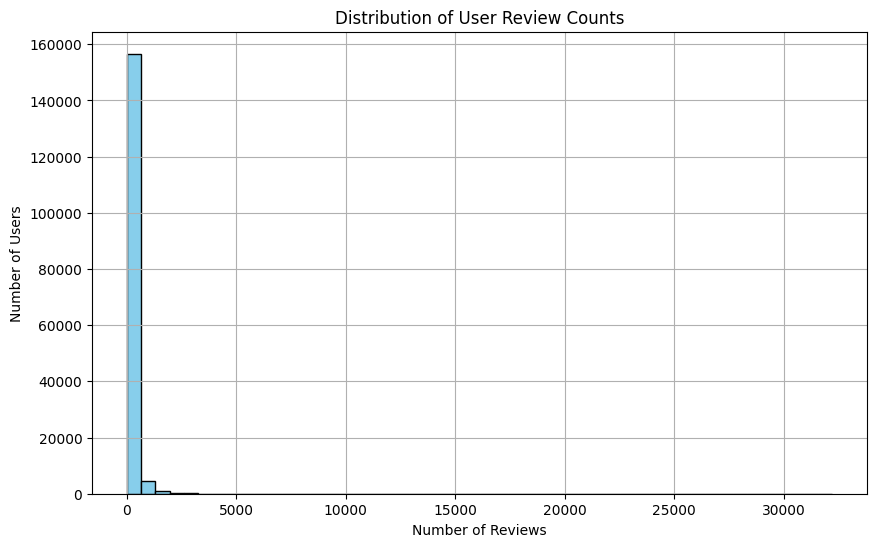

In [10]:
user_reviews_count = movies_rating_df['userId'].value_counts()
# user_reviews_count.head()
# user_reviews_count.tail()
user_reviews_count


# Plot the distribution
plt.figure(figsize=(10, 6))
plt.hist(user_reviews_count, bins=50, color='skyblue', edgecolor='black')
plt.title('Distribution of User Review Counts')
plt.xlabel('Number of Reviews')
plt.ylabel('Number of Users')
plt.grid(True)
plt.show()


#grande parte dos users tem poucas reviews e muitos poucos têm um número bastante elevado
#Esses devem ser professional critics ou spammers

# Data Preprocessing

# Recommendation System



## Content-based approach


In [11]:
mlb = MultiLabelBinarizer()
genres_encoded = pd.DataFrame(mlb.fit_transform(movies_df['genres'].str.split('|')), columns=mlb.classes_, index=movies_df.index)


#this will work for a specific user
User_id = 1
N = 5 # number of recommendations

def return_user_recommendations(User_id: int, N: int):
   # Filter DataFrame to include only ratings made by the specified user
   
   user_ratings = movies_rating_df[movies_rating_df['userId'] == User_id]

   # Convert genres into binary features using one-hot encoding
   genres_encoded = pd.DataFrame(mlb.transform(user_ratings['genres'].str.split('|')), columns=mlb.classes_, index=user_ratings.index)

   # Create user profile based on their ratings for movies with the same genres
   user_profile = genres_encoded.mean()

   # Calculate cosine similarity between user profile and all movies
   similarity_scores = cosine_similarity([user_profile], genres_encoded)

   # Get indices of movies sorted by similarity score in descending order
   sorted_indices = similarity_scores.argsort(axis=1)[:, ::-1].flatten()

   # Exclude movies the user has already rated
   unrated_indices = [index for index in sorted_indices if index not in user_ratings.index]

   # Recommend top N unrated movies
   top_n_recommendations = unrated_indices[:N]

   # Print recommendations
   print(f"Recommendations for User {User_id}:")
   for index in top_n_recommendations:
      movie_title = movies_df.iloc[index]['title']
      print(f"- {movie_title}")

return_user_recommendations(User_id, N)


Recommendations for User 1:
- From Dusk Till Dawn (1996)
- Clueless (1995)
- Dead Presidents (1995)
- Sabrina (1995)
- Assassins (1995)


## Collaborative/Social


In [12]:
# def collaborative_filtering_recommendation(user_id, N):
#     # Filter DataFrame to include ratings of the target user
#     target_user_ratings = movies_rating_df[movies_rating_df['userId'] == user_id]

#     # Calculate user-user similarity matrix using Pearson correlation
#     user_similarity_matrix = []
#     for index, row in movies_rating_df.iterrows():
#         if row['userId'] != user_id:
#             rating = row['rating']
#             if not pd.isnull(rating):  # Check if rating is not NaN
#                 similarity = pearsonr(target_user_ratings['rating'], rating)[0]
#                 user_similarity_matrix.append((index, similarity))

#     # Sort the user_similarity_matrix based on similarity value
#     user_similarity_matrix.sort(key=lambda x: x[1], reverse=True)

#     # Find top-k most similar users
#     similar_users_indices = [index for index, _ in user_similarity_matrix[:N]]

#     # Get ratings of similar users for items not rated by the target user
#     similar_users_ratings = movies_rating_df[movies_rating_df['userId'].isin(similar_users_indices)]

#     # Group by movieId and calculate mean rating of similar users
#     similar_users_ratings_grouped = similar_users_ratings.groupby('movieId')['rating'].mean().reset_index()
#     similar_users_ratings_grouped = pd.merge(movies_df, similar_users_ratings_grouped, on="movieId", how="inner")
#     similar_users_ratings_grouped.drop('genres', axis=1, inplace=True)

#     # Exclude movies already rated by the target user
#     unrated_movies = similar_users_ratings_grouped[~similar_users_ratings_grouped['movieId'].isin(target_user_ratings['movieId'])]

#     # Sort by predicted rating and recommend top N movies
#     top_n_recommendations = unrated_movies.sort_values(by='rating', ascending=False).head(N)

#     return top_n_recommendations

# # Example usage:
# user_id = 1
# N = 5  # Number of recommendations
# recommendations = collaborative_filtering_recommendation(user_id, N)
# print(f"Recommendations for User {user_id}:")
# print(recommendations)

TypeError: object of type 'float' has no len()